# Scientific Programming Lab

- Mathmatische Inhalte
  - Funktionen
  - Ableitung und Ableitungsregeln
      - Faktorregel
      - Potenzregel
      - Summenregel
      - Produktregel
      - Kettenregel
- Informatische Inhalte
  - Fortgeschrittene Konzepte der Vererbung und Objektorientierung
      - Mehrfachvererbung und Mixins
      - Interne Attribute
      - Datenklassen und Deep Copy
      - Typhinweise
      - Statische Methoden
      - Klassenmethoden
      - Abstrakte Basisklassen

## Funktionen und Ableitungen

<div class="definition">
    <h3>(Mathematische) Funktion</h3>
    <img src="images/x_squared.png" width=220 align=right alt="selfmade" />
    Eine Funktion ist eine Abbildung einer Ausgangsmenge $\mathbb{M}$ auf eine Zielmenge $\mathbb{N}$.<br>
    Diese Abbildung ordnet jedem Element der Ausgangsmenge  eindeutig ein Element auf der Zielmenge zu.<br>
    Wir nennen die Ausgangsmenge auch <em>Definitionsbereich/Eingabewerte</em> und die Zielmenge <em>Zielbereich/Funktionswerte</em>.<br>
    Eine Funktion wird mittels der beiden Mengen sowie einer Zuordnungsvorschrift definiert, z.B. beschreibt<br>
    $$f(x): \mathbb{R} \rightarrow \mathbb{R}, f(x)=x^2$$  <br>
    die Funktion, die jeder reellen Zahl ihr Quadrat zuordnet.
</div>

### Plottable-Mixin

Funktionen lassen sich als **Funktionsgraph** im Koordinatensystem visualisieren.

Dazu verwenden wir `Plottable`, ein *Mixin* für aufrufbare Klassen.

In [65]:
import matplotlib.pyplot as plt
import math

class Plottable():

    def sample(self, minimum : float, maximum : float, samples : int) -> [float]:
        sample_list = [self(minimum + (i / (samples -1.0) * (maximum - minimum))) for i in range(0, samples)]
        return sample_list


    @staticmethod
    def _get_x_values(minimum : float, maximum : float, samples : int) -> [float]:
        return [minimum + (i / (samples - 1.0) * (maximum - minimum)) for i in range(0, samples)]
    
    @staticmethod
    def multi_plot(plottables : [], minimum : float, maximum : float, samples : int = 100) -> None:
        plt.figure(figsize=(8, 6))
        x = Plottable._get_x_values(minimum, maximum, samples)
        for plottable in plottables:
            y = plottable.sample(minimum, maximum, samples)
            plt.plot(x, y, label=f"{plottable}")
        Plottable._configure_plot_and_show()

    def plot(self, minimum : float, maximum : float, samples : int = 100) -> None: 
        x = Plottable._get_x_values(minimum, maximum, samples)
        y = self.sample(minimum, maximum, samples)
        plt.plot(x, y, label=f"{self}")
        Plottable._configure_plot_and_show()

    @staticmethod
    def _configure_plot_and_show() -> None:
        # Axes and labels
        plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
        plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
        plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.show()

### Abstrakte Basisklasse für Funktionen

Wir möchten im Folgenden verschiedene Funktionen von $\mathbb{R}$ auf $\mathbb{R}$ und deren Ableitungen implementieren. 

Dazu verwenden wir eine abstrakte Basisklasse `MFunc`. Sie enthält folgende Methoden und Attribute:

- <tt>\_\_init\_\_</tt> Konstruktor, der den Namen, einen konstanten Faktor, und den Variablennamen erhält.
- <tt>_factor_str</tt> Hilfsfunktion für das Formatieren von Faktoren (z.B. `-1x -> -x`).
- <tt>\_\_call\_\_</tt> gibt den Funktionswert für einen Eingabewert zurück.
- <tt>clone</tt> erzeugt eine *deep copy* der Funktion.
- <tt>call_verbose</tt> gibt einen schön formatierten Output für eine Funktionsberechnung.

<div class="satz">
    <h3>Faktorregel</h3>
    Ein konstanter Faktor bleibt bei der Ableitung erhalten:<br>
    $$ f(x)=c \cdot g(x), \text{ mit } c \in \mathbb{R} \rightarrow f'(x) = c \cdot g'(x)$$
</div>

Daher können wir den `factor` in der Basisklasse zentral behandeln.

Alle Unterklassen müssen folgende abstrakte Methoden implementieren:

- <tt>_str_internal(self) -> str</tt> gibt die Berechnungsvorschrift der Funktion (ohne den Faktor) zurück.
- <tt>_call_internal(self, x: float) -> float</tt> berechnet den Funktionswert (ohne den Faktor).
- <tt>derive(self) -> MFunc</tt> gibt die Ableitungsfunktion der Funktion zurück (keinen konkreten Wert!).

In [66]:
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import copy

class MFunc(ABC, Plottable):
    '''
    Abstrakte Basisklasse für Funktionen.
    '''
    def __init__(self, name: str = '', factor: float = 1.0, operand : str ="x"):
        '''
        Konstruktor mit Funktionsname (z.B. f), konstantem Faktor, und Operand.
        '''
        self.name = name
        self.factor = factor
        self.operand = operand

    def _factor_str(self, factor: float) -> str:
        '''
        Hilfsmethode, die einen Faktor in einen String umwandelt:
        Faktor 1.0 kann weggelassen werden.
        Faktor -1.0 kann als Minus geschrieben werden.
        Alle anderen Faktoren werden als Zahl angegeben.
        '''
        return f"{'' if factor == 1.0 else '-' if factor == -1.0 else factor}"
    
    @abstractmethod
    def _str_internal(self) -> str:
        '''
        Wandelt die eigentliche Funktion in einen String um, ohne Faktor und Funktionssymbol.
        z.B. __str__: f(x)=3.0cos(x) -> _str_internal: cos(x)
        '''
        pass

    def __str__(self) -> str:
        '''
        Wandelt die Funktion in einen menschenlesbaren String um.
        '''
        return f"{self.name}({self.operand})={self._str_internal()}"

    @abstractmethod
    def _call_internal(self, x: float) -> float:
        '''
        Berechnet die eigentliche Funktion ohne Faktor.
        Ein Error wird als NaN (not a number) interpretiert.
        '''
        pass
    
    def __call__(self, x: float) -> float:
        '''
        Berechnet den Funktionswert an Stelle x.
        '''
        result = 0
        try:
            result = self._call_internal(x)
        except: #z.B. durch Teilen durch Null
            #print(f"Error at {self} {x}")
            return math.nan
        return self.factor * result

    @abstractmethod
    def derive(self):
        '''
        Gibt die Ableitungsfunktion dieser FUnktion zurück.
        '''
        pass

    @abstractmethod
    def integrate(self):
        '''
        Gibt eine Stammfunktion dieser Funktion zurück. c = 0
        '''
        pass

    def definite_integral(self, a, b):
        sf = self.integrate()
        return  sf(b) - sf(a)

    def newton(self, start, end):
        '''
        Gibt die Nullstellen der Funktion numerisch wieder
        '''
        table = []
        nullstellen = []

        step_factor = 0.1
        for i in range(start * int(1/step_factor), end * int(1/step_factor)):
            #table.append((i, self(i)))
            j = i * step_factor
            if self(j) == 0:
                nullstellen.append(j)
            
            elif self(j) * self(j + step_factor) < 0:
                table.append(j)

        if len(table) != 0:
            for ele in table:
                xn = ele - 1
                x0 = ele
                for l in range(31):
                    if self.derive()(x0) == 0: 
                        xn = x0 - self(x0)/(self.derive()(x0)+1e-5)
                    else:
                        xn = x0 - self(x0)/self.derive()(x0)
                    x0 = xn

                nullstellen.append(x0)
        
        nullstellen.sort()
        return nullstellen

    def definitions_luecken(self, start, end):
        luecken = [] 
        step_factor = 0.1
        for i in range(start * int(1/step_factor), end * int(1/step_factor)):
            if math.isnan(self(i)):
                luecken.append(i)

        return luecken

    def __untersumme(self, start, end, n):
        sum = 0
        width = abs(start - end) / n
        for i in range(n):
            x = start + i * width
            if not math.isnan(self(x)):
                sum += self(x) * width
        
        return abs(sum)

    def untersumme(self, start, end, n):
        '''
        Für die numerische Integration mit der Untersumme
        '''
        sum = 0
        nullstellen = self.newton(start, end)

        for i, ele in enumerate(nullstellen):
            if ele != start:
                sum += self.__untersumme(start, ele, n)
            
            if i < len(nullstellen)-1:
                sum += self.__untersumme(ele, nullstellen[i+1], n)
            else: 
                sum += self.__untersumme(ele, end, n)

        return sum

    def __obersumme(self, start, end, n):
        sum = 0
        width = abs(start - end) / n
        for i in range(1, n+1):
            x = start + i * width
            if not math.isnan(self(x)):
                sum += self(x) * width
        
        return abs(sum)

    def obersumme(self, start, end, n):
        '''
        Für die numerische Integration mit der Obersumme
        '''
        sum = 0
        nullstellen = self.newton(start, end)

        for i, ele in enumerate(nullstellen):
            if ele != start:
                sum += self.__obersumme(start, ele, n)
            
            if i < len(nullstellen)-1:
                sum += self.__obersumme(ele, nullstellen[i+1], n)
            else: 
                sum += self.__obersumme(ele, end, n)

        return sum

    def __trapezregel(self, start, end, n):
        sum = 0
        width = abs(start - end) / n
        for i in range(n):
            x1 = start + i * width
            x2 = start + (i+1) * width
            if not (math.isnan(self(x1)) or math.isnan(self(x2))):
                sum += 0.5 * (self(x1) + self(x2)) * width
            
        return abs(sum)

    def trapezregel(self, start, end, n):
        '''
        Für die numerische Integration mit der Trapezregel
        '''
        sum = 0
        nullstellen = self.newton(start, end)

        for i, ele in enumerate(nullstellen):
            if ele != start:
                sum += self.__trapezregel(start, ele, n)
            
            if i < len(nullstellen)-1:
                sum += self.__trapezregel(ele, nullstellen[i+1], n)
            else: 
                sum += self.__trapezregel(ele, end, n)

        return sum

    def clone(self):
        '''
        Erzeugt eine Kopie der funktion und aller ihrer Attribute.
        '''
        return copy.deepcopy(self)
    
    def call_verbose(self, x: float):
        '''
        Berechnet den Funktionswert an Stelle x und gibt ihn schön als String formatiert zurück.
        '''
        return f"{self.name}({x})={self(x)}"

### Konstante Funktionen

`ConstFunc` ist ein Beispiel für eine Unterklasse. Sie beschreibt Funktionen mit konstantem Funktionswert.

Die Ableitung einer solchen Funktion hat ebenfalls einen konstanten Funktionswert:


<div class="satz">
    <h3>Konstantenregel</h3>
    Ein konstanter Faktor fällt bei der Ableitung weg:<br>
    $$ f(x)=c, \text{ mit } c \in \mathbb{R} \rightarrow f'(x) = 0$$
</div>



In [67]:
import unittest

class ConstFunc(MFunc):

    def _str_internal(self) -> str:
        return f"{self.factor}"

    def _call_internal(self, x: float) -> float:
        '''
        Gibt immer 1 zurück, der Faktor kommt später hinzu.
        '''
        return 1

    def derive(self):
        return ConstFunc(self.name + "'", 0.0, self.operand)
    
    def integrate(self):
        return PowerFunc(self.name.upper(), self.factor, 1)

class TestConstFunc(unittest.TestCase):
    """
    Unittests für die konstante Funktion.
    """
    def setUp(self):
        """
        Initialisiere Variablen für den Test.
        """
        self.f  = ConstFunc("f", 1.0)
        self.g  = ConstFunc("g", 3.5)
        self.h  = ConstFunc("h", -2.0, 'y')
        self.k  = ConstFunc("k", 0.0)

    def test_01_call(self):
        """
        Testet korrekte Berechnung.
        """
        self.assertAlmostEqual(self.f(1.0), 1.0)
        self.assertAlmostEqual(self.f(-10.0), 1.0)
        self.assertAlmostEqual(self.g(0.0), 3.5)
        self.assertAlmostEqual(self.h(0.0), -2.0)
        self.assertAlmostEqual(self.k(11.5), 0.0)

    def test_02_str(self):
        """
        Testet korrekte Ausgabe als String.
        """
        self.assertEqual(str(self.f),'f(x)=1.0')
        self.assertEqual(str(self.g),'g(x)=3.5')
        self.assertEqual(str(self.h),'h(y)=-2.0')
        self.assertEqual(str(self.k),'k(x)=0.0')

    def test_03_derive(self):
        """
        Testet Ableitung.
        """
        fd= self.f.derive()
        hd= self.h.derive()
        self.assertTrue(type(fd) is ConstFunc)
        self.assertEqual(fd.factor, 0.0)
        self.assertEqual(fd.operand, 'x')
        self.assertEqual(str(fd), "f'(x)=0.0")
        self.assertTrue(type(hd) is ConstFunc)
        self.assertEqual(hd.factor, 0.0)
        self.assertEqual(hd.operand, 'y')
        self.assertEqual(str(hd), "h'(y)=0.0")


if __name__ == '__main__':
    # Test Integration
    f = ConstFunc("f", 7)
    print(f.integrate())

    #Durchführung der Tests
    loader = unittest.TestLoader()
    suite = unittest.TestSuite()

    #Hier können einzelne Tests auskommentiert werden
    suite.addTest(TestConstFunc("test_01_call"))
    suite.addTest(TestConstFunc("test_02_str"))
    suite.addTest(TestConstFunc("test_03_derive"))

    runner = unittest.TextTestRunner()
    runner.run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 0.003s

OK


F(x)=7x


Nun können wir die Klasse ausprobieren.

c(x)=7.0 c(2.0)=7.0
c'(x)=0.0 c'(5.0)=0.0


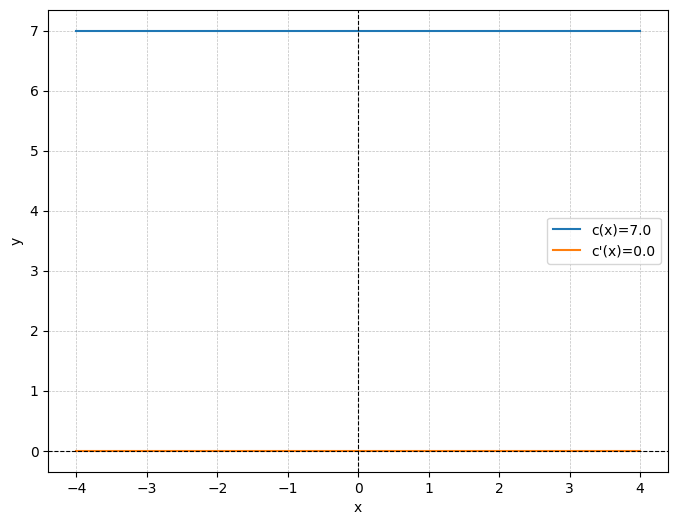

In [68]:
c = ConstFunc("c", 7.0)
cd = c.derive()
print(c, c.call_verbose(2.0))
print(cd, cd.call_verbose(5.0))

Plottable.multi_plot([c, cd], -4.0, 4.0)

### $e$-Funktion

<div class="definition">
    <h3>Eulersche Zahl und $e$-Funktion</h3>
    <img src="images/exp_x.png" width=260 align=right alt="selfmade" />
    Die Eulersche Zahl ist wie folgt definiert:<br>
    $$  e = \lim_{n \to \infty} \left(1 + \frac{1}{n}\right)^n
    $$<br>
    Sie ist eine wichtige Größe der Mathematik und wird z.B. bei der Berechnung natürlichen Wachstums eingesetzt.<br>
    Basierend auf $e$ ist die natürliche Exponentialfunktion oder $e$-Funktion definiert:<br>
    $$ f(x) = e^x $$
</div>


    $$ 
    f(x) = e^x \rightarrow f'(x) = e^
    f(x)= e^{c \cdot x}, \text{ mit } c \in \mathbb{R} \rightarrow f'(x) = c \cdot e^{c \cdot x}
    $$


Wir möchten im Folgenden die $e$-Funktion als `ExpFunc` implementieren. Ein Teil der Implementierung ist bereits vorhanden. Auch die Eulersche Zahl steht als Konstante `math.e` bereits zur Verfügung.

<div class="aufgabe">
    <h3>$e$-Funktion</h3>
    Ergänzen Sie den untenstehenden Code der Klasse <tt>ExpFunc</tt>.<br>
    Stellen Sie sicher, dass alle Tests durchlaufen!<br>
    Folgende Funktionen sind zu ergänzen:
    <ul>
    <li><tt>_call_internal(self, x: float) -> float</tt>: Berechnen Sie die Funktion unter Berücksichtigung des <tt>exp_factor</tt> (wie $c$ in obiger Formel).
    </li>
    <li><tt>derive(self) -> MFunc</tt>: Geben Sie die Ableitung als neue <tt>ExpFunc</tt> mit korrekten Faktoren zurück.
    </li>
    </ul>
</div>

In [69]:
import math
import unittest

class ExpFunc(MFunc):
    
    def __init__(self, name: str = '', factor: float = 1.0, exp_factor: float = 1.0, operand : str ="x"):
        super().__init__(name, factor, operand)
        self.exp_factor = exp_factor
        
    def _str_internal(self) -> str:
        exponent = f"{self._factor_str(self.exp_factor)}{self.operand}"
        if(abs(self.exp_factor) != 1.0 or len(self.operand) > 1):
            exponent = f"({exponent})"
        return f"{self._factor_str(self.factor)}e^{exponent}"

    def _call_internal(self, x: float) -> float:
        return math.pow(math.e, self.exp_factor*x)

    def derive(self) -> MFunc:
        return ExpFunc(self.name+"'", self.factor * self.exp_factor, self.exp_factor, self.operand)

    def  integrate(self):
        return ExpFunc(self.name.upper(), self.factor * (1/self.exp_factor), self.exp_factor)

    def __eq__(self, other):
        '''
        Gleichtheit bis auf den Faktor
        '''
        return self.exp_factor == other.exp_factor and self.operand == other.operand
    

class TestExpFunc(unittest.TestCase):
    """
    Unittests für die e-Funktion.
    """
    def setUp(self):
        """
        Initialisiere Variablen für den Test.
        """
        self.f  = ExpFunc("f", 1.0)
        self.g  = ExpFunc("g", 2.0, 3.0)
        self.h  = ExpFunc("h", -1.0, -2.0, 'y')

    def test_01_call(self):
        """
        Testet korrekte Berechnung.
        """
        self.assertAlmostEqual(self.f(0.0), 1.0)
        self.assertAlmostEqual(self.f(1.0), math.e)
        self.assertAlmostEqual(self.f(3.0), 20.085536923187664)
        self.assertAlmostEqual(self.g(2.0), 806.85758698547)
        self.assertAlmostEqual(self.g(-2.0), 0.004957504353332719)
        self.assertAlmostEqual(self.h(4.0), -0.00033546262790251196)
        self.assertAlmostEqual(self.h(-4.0), -2980.957987041727)

    def test_02_str(self):
        """
        Testet korrekte Ausgabe als String.
        """
        self.assertEqual(str(self.f),'f(x)=e^x')
        self.assertEqual(str(self.g),'g(x)=2.0e^(3.0x)')
        self.assertEqual(str(self.h),'h(y)=-e^(-2.0y)')

    def test_03_derive(self):
        """
        Testet Ableitung.
        """
        fd= self.f.derive()
        gd= self.g.derive()
        hd= self.h.derive()
        self.assertTrue(type(fd) is ExpFunc)
        self.assertEqual(fd.name, "f'")
        self.assertEqual(fd.factor, 1.0)
        self.assertEqual(fd.exp_factor, 1.0)
        self.assertEqual(fd.operand, 'x')
        self.assertEqual(str(gd),"g'(x)=6.0e^(3.0x)")
        self.assertAlmostEqual(gd(2.5), 10848.254486736376)
        self.assertEqual(str(hd),"h'(y)=2.0e^(-2.0y)")
        self.assertAlmostEqual(hd(1.0), 0.2706705664732254)


if __name__ == '__main__':
    # Test Integration
    f = ExpFunc("f", 1, 2)
    print(f)
    print(f.integrate())
    print(f.integrate().integrate())

    #Durchführung der Tests
    loader = unittest.TestLoader()
    suite = unittest.TestSuite()

    #Hier können einzelne Tests auskommentiert werden
    suite.addTest(TestExpFunc("test_01_call"))
    suite.addTest(TestExpFunc("test_02_str"))
    suite.addTest(TestExpFunc("test_03_derive"))

    runner = unittest.TextTestRunner()
    runner.run(suite)

.

f(x)=e^(2x)
F(x)=0.5e^(2x)
F(x)=0.25e^(2x)


..
----------------------------------------------------------------------
Ran 3 tests in 0.004s

OK


Auch diese Funktion können wir uns plotten lassen:

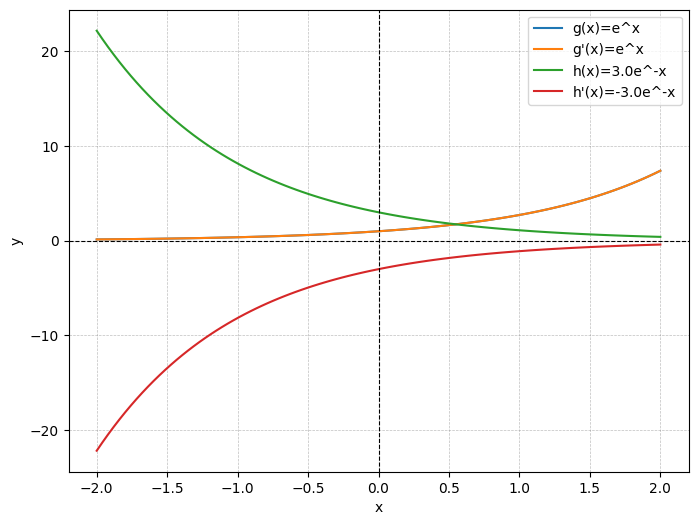

In [70]:
g = ExpFunc("g")
h = ExpFunc("h", 3.0, -1.0)

Plottable.multi_plot([g, g.derive(), h, h.derive()], -2, 2, 100)

### Sinus und Cosinus

Als nächstes möchten wir Funktionen für *Sinus* und *Cosinus* implementieren. Die eigentliche Berechnung müssen Sie nicht selbst vornehmen, `math.sin` und `math.cos` gibt es bereits.

<div class="satz">
    <h3>Ableitung von Sinus und Cosinus</h3>
    
    $$ f(x) = sin(x) \rightarrow f'(x) = cos(x)$$<br>
    $$ f(x) = sin(c \cdot x), \text{ mit } c \in \mathbb{R} \rightarrow f'(x) = c \cdot cos(c \cdot x)$$<br>
    $$ f(x) = cos(x) \rightarrow f'(x) = -sin(x)$$<br>
    $$ f(x) = cos(c \cdot x), \text{ mit } c \in \mathbb{R} \rightarrow f'(x) = c \cdot -sin(c \cdot x)$$
</div>

<div class="aufgabe">
    <h3>Sinus- und Cosinus-Funktion</h3>
    Ergänzen Sie den untenstehenden Code der Klasse <tt>SinFunc</tt>.<br>
    Erstellen Sie danach analog eine Klasse <tt>CosFunc</tt>.<br>
    Stellen Sie sicher, dass alle Tests durchlaufen!
</div>


In [71]:
import math
import unittest

class SinFunc(MFunc):

    def __init__(self, name: str = '', factor: float = 1.0, sin_factor: float = 1.0, operand : str ="x"):
        super().__init__(name, factor, operand)
        self.sin_factor = sin_factor
        
    def _str_internal(self) -> str:
        return f"{self._factor_str(self.factor)}sin({self._factor_str(self.sin_factor)}{self.operand})"

    def _call_internal(self, x: float) -> float:
        return math.sin(self.sin_factor * x)

    def derive(self) -> MFunc:
        return CosFunc(self.name + "'", self.factor * self.sin_factor, self.sin_factor, self.operand) 

    def integrate(self):
        return CosFunc(self.name.upper(), self.factor * (-1/self.sin_factor), self.sin_factor)
    
    def __eq__(self, other):
        '''
        Gleichtheit bis auf den Faktor
        '''
        return self.sin_factor == other.sin_factor and self.operand == other.operand

class CosFunc(MFunc):

    def __init__(self, name: str = '', factor: float = 1.0, cos_factor: float = 1.0, operand : str ="x"):
        super().__init__(name, factor, operand)
        self.cos_factor = cos_factor
        
    def _str_internal(self) -> str:
        return f"{self._factor_str(self.factor)}cos({self._factor_str(self.cos_factor)}{self.operand})"

    def _call_internal(self, x: float) -> float:
        return math.cos(self.cos_factor * x)

    def derive(self) -> MFunc:
        return SinFunc(self.name + "'", (-1) * self.factor * self.cos_factor, self.cos_factor, self.operand) 

    def integrate(self):
        return SinFunc(self.name.upper(), self.factor * (1/self.cos_factor), self.cos_factor)

    def __eq__(self, other):
        '''
        Gleichtheit bis auf den Faktor
        '''
        return self.cos_factor == other.cos_factor and self.operand == other.operand

class TestSinCos(unittest.TestCase):
    """
    Unittests für die Sinus- und Cosinus-Funktionen.
    """
    def setUp(self):
        """
        Initialisiere Variablen für den Test.
        """
        self.fs  = SinFunc("f", 1.0)
        self.gs  = SinFunc("g", 3.0, 2.0, 'y')
        self.fc  = CosFunc("f", 1.0, 1.0)
        self.gc  = CosFunc("g", -3.0, -2.0, 'y')

    def test_01_call_sin(self):
        """
        Testet korrekte Berechnung.
        """
        self.assertAlmostEqual(self.fs(0.0), 0.0)
        self.assertAlmostEqual(self.fs(math.pi/2), 1.0)
        self.assertAlmostEqual(self.fs(math.pi), 0.0)
        self.assertAlmostEqual(self.fs(1.0), 0.8414709848078965)
        self.assertAlmostEqual(self.gs(0.0), 0.0)
        self.assertAlmostEqual(self.gs(-math.pi/2), 0.0)
        self.assertAlmostEqual(self.gs(-math.pi), 0.0)
        self.assertAlmostEqual(self.gs(1.0), 2.727892280477045)

    def test_02_call_cos(self):
        """
        Testet korrekte Berechnung.
        """
        self.assertAlmostEqual(self.fc(0.0), 1.0)
        self.assertAlmostEqual(self.fc(math.pi/2), 0.0)
        self.assertAlmostEqual(self.fc(math.pi), -1.0)
        self.assertAlmostEqual(self.gc(1.0), 1.2484405096414273)
        

    def test_03_str_sin(self):
        """
        Testet korrekte Ausgabe als String.
        """
        self.assertEqual(str(self.fs),'f(x)=sin(x)')
        self.assertEqual(str(self.gs),'g(y)=3.0sin(2.0y)')

    def test_04_str_cos(self):
        """
        Testet korrekte Ausgabe als String.
        """
        self.assertEqual(str(self.fc),'f(x)=cos(x)')
        self.assertEqual(str(self.gc),'g(y)=-3.0cos(-2.0y)')
    
    def test_05_derive_once(self):
        """
        Testet Ableitung.
        """
        fsd= self.fs.derive()
        gsd= self.gs.derive()
        fcd= self.fc.derive()
        gcd= self.gc.derive()
        self.assertTrue(type(fsd) is CosFunc)
        self.assertEqual(fsd.factor, 1.0)
        self.assertEqual(fsd.cos_factor, 1.0)
        self.assertEqual(fsd.operand, 'x')
        self.assertEqual(fsd._str_internal(), self.fc._str_internal())
        self.assertEqual(str(gsd), "g'(y)=6.0cos(2.0y)")
        self.assertEqual(str(fcd), "f'(x)=-sin(x)")
        self.assertEqual(str(gcd), "g'(y)=-6.0sin(-2.0y)")

    def test_06_derive_multiple(self):
        fsd= self.fs.derive().derive().derive().derive()
        fcd= self.fc.derive().derive().derive().derive()
        self.assertEqual(str(fsd), "f''''(x)=sin(x)")
        self.assertEqual(str(fcd), "f''''(x)=cos(x)")

        gsd= self.gs.derive().derive()
        gcd= self.gc.derive().derive()
        self.assertEqual(str(gsd), "g''(y)=-12.0sin(2.0y)")
        self.assertEqual(str(gcd), "g''(y)=12.0cos(-2.0y)")

        

if __name__ == '__main__':

    #Test Integration
    f = SinFunc("f", 1, 2)
    print(f)
    print(f.integrate())
    print(f.integrate().integrate())
    print(f.definite_integral(0, 2))

    #Test Newton
    g = SinFunc("g", 1.0, 1.0)
    #print("Output Newton:", g.newton(-4, 4))

    #Durchführung der Tests
    loader = unittest.TestLoader()
    suite = unittest.TestSuite()

    #Hier können einzelne Tests auskommentiert werden
    suite.addTest(TestSinCos("test_01_call_sin"))
    suite.addTest(TestSinCos("test_02_call_cos"))
    suite.addTest(TestSinCos("test_03_str_sin"))
    suite.addTest(TestSinCos("test_04_str_cos"))
    suite.addTest(TestSinCos("test_05_derive_once"))
    suite.addTest(TestSinCos("test_06_derive_multiple"))

    runner = unittest.TextTestRunner()
    runner.run(suite)


......
----------------------------------------------------------------------
Ran 6 tests in 0.006s

OK


f(x)=sin(2x)
F(x)=-0.5cos(2x)
F(x)=-0.25sin(2x)
0.8268218104318059


Auch die Funktionsgraphen von Sinus und Cosinus lassen sich mittels Plottable zeichnen.

Leitet man $sin(x)$ viermal ab, ist das Ergebnis übrigens wieder $sin(x)$.

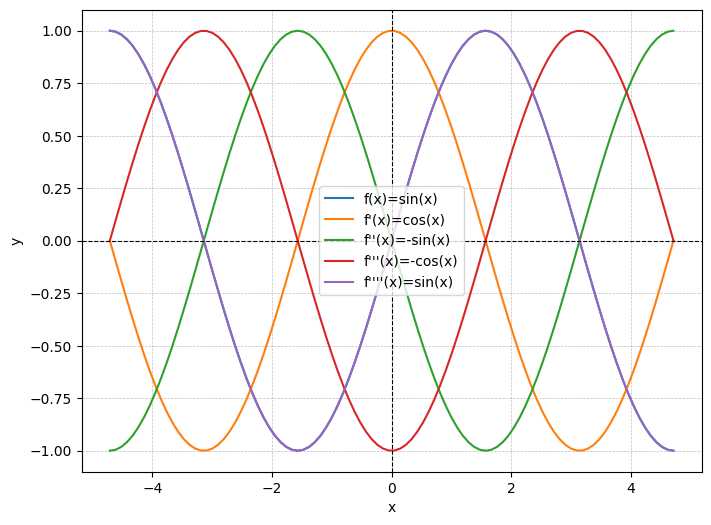

In [72]:
f = SinFunc("f")#, 1, 2
Plottable.multi_plot([f, 
                      f.derive(),
                      f.derive().derive(),
                      f.derive().derive().derive(),
                      f.derive().derive().derive().derive()],
                    -math.pi * 1.5, math.pi  * 1.5, 100)

### Potenzfunktion

Die nächsten Funktionen sind Potenzfunktionen, also Funktionen, in dem x mit einem Exponenten kombiniert wird, z.B. $x^3$.


<div class="satz">
    <h3>Potenzregel</h3>
    <img src="images/x_cubed.png" width=220 align=right alt="selfmade" />
    $$ f(x) = x^n, \text{ mit } n \in \mathbb{N}^{+} \rightarrow f'(x) = n \cdot x^{n-1}$$<br>
    Das heißt insbesondere:
    $$ f(x) = x \rightarrow f'(x) = 1 \cdot x^0 = 1 \cdot 1 = 1 $$<br>
</div>

<div class="aufgabe">
    <h3>Potenzfunktion</h3>
    Ergänzen Sie den untenstehenden Code der Klasse <tt>PowerFunc</tt>.<br>
    Beachten Sie, dass die Ableitung entweder eine Potenz- oder eine Konstantenfunktion sein kann.<br>
    Stellen Sie sicher, dass alle Tests durchlaufen!
</div>


In [73]:
import unittest

class PowerFunc(MFunc):
    
    def __init__(self, name: str = '', factor: float = 1.0, exponent: float = 1.0, operand : str ="x"):
        super().__init__(name, factor, operand)
        self.exponent = exponent
        
    def _str_internal(self) -> str:
        return f"{self._factor_str(self.factor)}{self.operand}{'' if self.exponent == 1 else f'^{self.exponent}'}"

    def _call_internal(self, x: float) -> float:
        #print("[DEBUG Power]", self._str_internal(self), x, self.exponent)
        return math.pow(x, self.exponent)

    def derive(self) -> MFunc:
        if self.exponent == 1: return ConstFunc(self.name + "'", self.factor, self.operand)
        return PowerFunc(self.name + "'", self.factor * self.exponent, self.exponent - 1, self.operand) 
    
    def integrate(self):
        if self.exponent == -1:
            print("x^-1 Klappt leider nicht ╮（╯＿╰）╭")
            # Wäre ln(abs(x)), es gibt aber keine Klasse dafür
            return None
        return PowerFunc(self.name.upper(), self.factor * (1/(self.exponent+1)), self.exponent+1)

    def __eq__(self, other):
        '''
        Gleichtheit bis auf den Faktor
        '''
        return self.exponent == other.exponent and self.operand == other.operand

class TestPowerFunc(unittest.TestCase):
    """
    Unittests für die Potenz-Funktion.
    """
    def setUp(self):
        """
        Initialisiere Variablen für den Test.
        """
        self.f  = PowerFunc("f", 1.0, 2.0)
        self.g  = PowerFunc("g", -3.0, 1.0)
        self.h  = PowerFunc("h", 0.5, 3.0, 'y')

    def test_01_call(self):
        """
        Testet korrekte Berechnung.
        """
        self.assertAlmostEqual(self.f(1.0), 1.0)
        self.assertAlmostEqual(self.f(3.0), 9.0)
        self.assertAlmostEqual(self.f(-2.5), 6.25)
        self.assertAlmostEqual(self.g(0.0), 0.0)
        self.assertAlmostEqual(self.g(2.0), -6.0)
        self.assertAlmostEqual(self.h(0.5), 0.0625)
        self.assertAlmostEqual(self.h(-1.5), -1.6875)
        
    def test_02_str(self):
        """
        Testet korrekte Ausgabe als String.
        """
        self.assertEqual(str(self.f),'f(x)=x^2.0')
        self.assertEqual(str(self.g),'g(x)=-3.0x')
        self.assertEqual(str(self.h),'h(y)=0.5y^3.0')

    def test_03_derive_to_power(self):
        """
        Testet Ableitung auf eine andere Potenzfunktion.
        """
        fd= self.f.derive()
        hd= self.h.derive()
        hdd= hd.derive()

        self.assertTrue(type(fd) is PowerFunc)
        self.assertEqual(fd.factor, 2.0)
        self.assertEqual(fd.exponent, 1.0)
        self.assertEqual(fd.operand, 'x')
        self.assertEqual(str(fd), "f'(x)=2.0x")
        self.assertEqual(str(hd), "h'(y)=1.5y^2.0")
        self.assertEqual(str(hdd), "h''(y)=3.0y")

    def test_04_derive_to_const(self):
        """
        Testet Ableitung zur Konstantenfunktion.
        """
        gd= self.g.derive()
        gdd= self.g.derive().derive()
        fdd= self.f.derive().derive()
        self.assertTrue(type(gd) is ConstFunc)
        self.assertTrue(type(gdd) is ConstFunc)
        self.assertTrue(type(fdd) is ConstFunc)
        self.assertEqual(str(gd), "g'(x)=-3.0")
        self.assertEqual(str(gdd), "g''(x)=0.0")
        self.assertEqual(str(fdd), "f''(x)=2.0")

if __name__ == '__main__':

    #Test Integration
    g = PowerFunc("g", 1, -2)
    print(g)
    print(g.integrate())

    #Test Untersumme
    f = PowerFunc("f", 1, 2)
    F = PowerFunc("F", 1/3, 3)
    print(f.untersumme(-1, 1, 50))
    print(F(1) - F(-1))

    #Durchführung der Tests
    loader = unittest.TestLoader()
    suite = unittest.TestSuite()

    #Hier können einzelne Tests auskommentiert werden
    suite.addTest(TestPowerFunc("test_01_call"))
    suite.addTest(TestPowerFunc("test_02_str"))
    suite.addTest(TestPowerFunc("test_03_derive_to_power"))
    suite.addTest(TestPowerFunc("test_04_derive_to_const"))
    
    runner = unittest.TextTestRunner()
    runner.run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.005s

OK


g(x)=x^-2
G(x)=-x^-1
0.6668000000000001
0.6666666666666666


Durch mehrfaches Ableiten lässt sich gut erkennen, wie der *Grad* (größter Exponent) der Funktion sinkt.

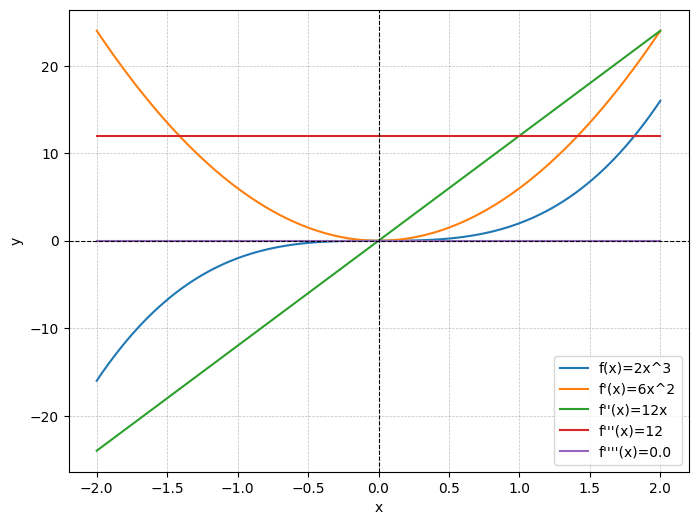

In [74]:
f = PowerFunc("f", 2, 3)
Plottable.multi_plot([f,
                      f.derive(),
                      f.derive().derive(),
                      f.derive().derive().derive(),
                      f.derive().derive().derive().derive()],
                    -2, 2)

### Summenregel

Viele Funktionen setzen sich aus mehreren der bisher implementierten Funktionen zusammen. Eine wichtige Klasse sind Polynome, also Funktionen der Form:

$$
f(x)= c_0 \cdot x^0 + c_1 \cdot x^1 + c_2 \cdot x^2 + ... + c_{n-1} \cdot x^{n-1} + c_{n} \cdot x^{n}, \text{ mit } c_{0 \ldots n} \in \mathbb{R}
$$

Für die Ableitung solche einer Funktion hilft eine neue Ableitungsregel.

$$ 
f(x) = (f_1{x} + f_2{x} + \ldots + f_n{x}) \rightarrow f'(x) = (f_1'{x} + f_2'{x} + \ldots + f_n'{x})
$$

Wir können also die Terme der Summe einfach einzeln ableiten.


<div class="aufgabe">
    <h3>Summen-Funktion</h3>
    <img src="images/x_plus_sin.png" width=260 align=right alt="selfmade" />
    Ergänzen Sie den untenstehenden Code der Klasse <tt>SumFunc</tt>, die eine Summe aus mehreren anderen Funktionen (<tt>terms</tt>) ist.<br>
    Stellen Sie sicher, dass alle Tests durchlaufen!<br>
    Folgende Vorgaben gelten:
    <ul>
    <li><tt>_str_internal(self) -> str</tt>: Wir umgeben die Summe mit Klammern, um später Punkt-vor-Strich nicht zu verletzen (z.B. <tt>(sin(x)+cos(x))</tt>)
    </li>    
    <li><tt>_call_internal(self, x: float) -> float</tt>: Berechnen Sie die Funktion durch Aufruf der einzelnen Terme.
    </li>
    <li><tt>derive(self) -> MFunc</tt>: Terme mit Faktor 0 fallen weg. Hat die Ableitung nur einen Summanden, geben Sie diesen direkt als Ableitung zurück. Bleibt kein Term übrig, geben Sie eine passende Konstantenfunktion zurück.
    </li>
    </ul>
</div>

<details class="hint">
<summary></summary>
    Ob ein Plus oder Minus kommt, hängt vom Vorzeichen des Faktors ab.
    <details class="nexthint">
    <summary></summary>
       Bei der Ableitung fallen Terme mit Faktor 0.0 weg.
        <details class="nexthint">
        <summary></summary>
           Es gibt drei Fälle, welche Art von Func die Ableitung liefert, abhängig von der Anzahl der verbleibenden Terme.
        </details>
    </details>
</details>


In [91]:
import unittest

class SumFunc(MFunc):

    def __init__(self, name: str, terms: [MFunc]):
        super().__init__(name)
        self.terms = []
        for term in terms:
            self.terms.append(term.clone())
        
    def _str_internal(self) -> str:
        out = "("

        for i, ele in enumerate(self.terms):
            if ele.factor != 0:
                if ele.factor > 0 and i != 0: out += "+"
                out += ele._str_internal()

        return out + ")"

    def _call_internal(self, x: float) -> float:
        sum = 0
        for ele in self.terms:
            sum += ele(x)

        return sum

    def derive(self) -> MFunc:
        newTerms = []
        for ele in self.terms:
            if not ("0.0" in str(ele.derive())): newTerms.append(ele.derive())
        
        if len(newTerms) == 1: 
            if type(newTerms[0]) == ConstFunc: return ConstFunc(self.name + "'", newTerms[0].factor, newTerms[0].operand) 
            elif type(newTerms[0]) == PowerFunc: return PowerFunc(self.name + "'", newTerms[0].factor, newTerms[0].exponent, newTerms[0].operand)
        return SumFunc(self.name + "'", newTerms)
        
    def __len__(self):
        return len(self.terms)
    
    def integrate(self):
        newTerms = []
        for ele in self.terms:
            newTerms.append(ele.integrate())
        return SumFunc(self.name.upper(), newTerms)

    # Funktioniert bis jetzt nicht
    def simplify(self):
        for i, ele in enumerate(self.terms):
            for j in range(i, len(self)-1): 
                if type(ele) == type(self.terms[j]):
                    if type(ele) == ConstFunc:
                        print("TEST CONST", self.terms[j].factor, ele.factor)
                        self.terms[j].factor += ele.factor
                        print(self.terms[j].factor)
                        self.terms.pop(i)

                    elif ele == self.terms[j]:
                        self.terms[j].factor += ele.factor
                        self.terms.pop(i)

class TestSumFunc(unittest.TestCase):
    """
    Unittests für die zusammengestzte Summen-Funktion.
    """
    def setUp(self):
        """
        Initialisiere Variablen für den Test.
        """
        self.f  = SumFunc("f",[PowerFunc("", 1.0, 3.0), PowerFunc("", 1.0, 2.0), PowerFunc("", 1.0, 1.0)])
        self.g  = SumFunc("g",[PowerFunc("", 2.5, 2.0), PowerFunc("", -4.0, 1.0), ConstFunc("", 3.0)])
        self.h  = SumFunc("h", [SinFunc(), CosFunc("",3.0, 0.5), ConstFunc("", -1.0)])
        self.k  = SumFunc("k", [PowerFunc("", 1.0, 4.0), PowerFunc("", 5.0, 1.0)])

    def test_01_call(self):
        """
        Testet korrekte Berechnung.
        """
        self.assertAlmostEqual(self.f(2.0), 14.0)
        self.assertAlmostEqual(self.f(3.0), 39.0)
        self.assertAlmostEqual(self.g(0.0), 3.0)
        self.assertAlmostEqual(self.g(3.0), 13.5)
        self.assertAlmostEqual(self.g(-1.0), 9.5)
        self.assertAlmostEqual(self.h(math.pi), -1.0)
        self.assertAlmostEqual(self.h(math.pi/2), 2.121320343559643)
        
    def test_02_str(self):
        """
        Testet korrekte Ausgabe als String.
        """
        self.assertEqual(str(self.f),"f(x)=(x^3.0+x^2.0+x)")
        self.assertEqual(str(self.g),"g(x)=(2.5x^2.0-4.0x+3.0)")
        self.assertEqual(str(self.h),"h(x)=(sin(x)+3.0cos(0.5x)-1.0)")

    def test_03_derive_once(self):
        """
        Testet einmalige Ableitung.
        """
        fd= self.f.derive()
        gd= self.g.derive()
        hd= self.h.derive()
        
        self.assertTrue(type(fd) is SumFunc)
        self.assertEqual(fd.factor, 1.0)
        self.assertEqual(fd.operand, 'x')
        self.assertIn("f'(x)=(", str(fd))
        self.assertIn("3.0x^2.0", str(fd))
        self.assertIn("2.0x", str(fd))
        self.assertIn("1.0", str(fd))
        self.assertAlmostEqual(fd(3.0), 34.0)
        
        self.assertEqual(len(gd.terms), 2)
        self.assertNotIn("0.0", str(gd))
        self.assertIn("4.0", str(gd))
        self.assertIn("5.0x", str(gd))
        self.assertAlmostEqual(gd(-2.0), -14.0)

        self.assertIn("cos(x)", str(hd))
        self.assertIn("-1.5sin(0.5x)", str(hd))
        self.assertAlmostEqual(hd(math.pi), -2.5)
        
        #self.assertEqual(str(fd), "f'(x)=2.0x")
        #self.assertEqual(str(hd), "h'(y)=1.5y^2.0")
        #self.assertEqual(str(hdd), "h''(y)=3.0y")

    def test_04_derive_multiple(self):
        """
        Testet mehrfache Ableitung und Wegfall von Konstanten.
        """
        
        fdd= self.f.derive().derive()
        fddd= self.f.derive().derive().derive()
        kdd= self.k.derive().derive()
        
        #print([str(ele) for ele in fdd.terms])

        self.assertEqual(len(fdd.terms), 2)
        self.assertIn("f''(x)=(", str(fdd))
        self.assertIn("6.0x", str(fdd))
        self.assertIn("+2.0", str(fdd))

        self.assertTrue(type(fddd) is ConstFunc)
        self.assertEqual(str(fddd), "f'''(x)=6.0")

        self.assertTrue(type(kdd) is PowerFunc)
        self.assertEqual(str(kdd), "k''(x)=12.0x^2.0")

    #Bonus-Aufgabe
    def test_11_simplify(self):
        """
        Testet Die Vereinfachung/Zusammenfasung der Summe.
        """
        s1 = SumFunc("s", [ConstFunc("", 17.0), ConstFunc("", 4.0)])
        self.assertEqual(len(s1.terms), 1)
        self.assertEqual(str(s1), "s(x)=(21.0)")
        self.assertEqual(s1(0.0), 21.0)

        s2 = SumFunc("s", [PowerFunc("", 3.0, 2.0), PowerFunc("", 4.0, 3.0), PowerFunc("", 1.0, 2.0), PowerFunc("", -1.0, 3.0)])
        self.assertEqual(len(s2.terms), 2)
        self.assertIn("4.0x^2.0", str(s2))
        self.assertIn("3.0x^3.0", str(s2))
        self.assertEqual(s2(3.0), 117.0)

        s3 = SumFunc("s", [PowerFunc("", 1.0, 3.0), PowerFunc("", -1.0, 3.0), PowerFunc("", 2.0, 1.0)])
        self.assertEqual(len(s3.terms), 1)
        self.assertEqual(str(s3), "s(x)=(2.0x)")
        self.assertEqual(s3(3.0), 6.0)

        s4 = SumFunc("s", [SumFunc("", [PowerFunc("", 1.0, 3.0), PowerFunc("", 2.0, 1.0)]), PowerFunc("", -1.0, 3.0), PowerFunc("", 1.0, 2.0)])
        self.assertEqual(len(s4.terms), 2)
        self.assertIn("2.0x", str(s4))
        self.assertIn("x^2.0", str(s4))
        self.assertEqual(s4(3.0), 15.0)
      
if __name__ == '__main__':

    # Test Simplify 
    h = SumFunc("h", [ConstFunc("", 1), ConstFunc("", 1)])
    print(h)
    h.simplify()
    print(h)

    # Test Integration
    f = SumFunc("f", [PowerFunc("", 1, 2), ExpFunc("", 1, 2), SinFunc("", 2, 1)])
    print(f)
    print(f.integrate())

    # Test Untersumme
    g = SumFunc("g", [PowerFunc("", 1, 2), PowerFunc("", -1, -1)])
    print(g.untersumme(-1, 2, 50))

    #Durchführung der Tests
    loader = unittest.TestLoader()
    suite = unittest.TestSuite()

    #Hier können einzelne Tests auskommentiert werden
    suite.addTest(TestSumFunc("test_01_call"))
    suite.addTest(TestSumFunc("test_02_str"))
    suite.addTest(TestSumFunc("test_03_derive_once"))
    suite.addTest(TestSumFunc("test_04_derive_multiple"))
    #Bonus-Aufgabe
    suite.addTest(TestSumFunc("test_11_simplify"))
    
    runner = unittest.TextTestRunner()
    runner.run(suite)

....F
FAIL: test_11_simplify (__main__.TestSumFunc.test_11_simplify)
Testet Die Vereinfachung/Zusammenfasung der Summe.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "c:\temp\rdstemp\OSC\ipykernel_10124\3804866123.py", line 155, in test_11_simplify
    self.assertEqual(len(s1.terms), 1)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^
AssertionError: 2 != 1

----------------------------------------------------------------------
Ran 5 tests in 0.014s

FAILED (failures=1)


h(x)=(1+1)
TEST CONST 1 1
2
h(x)=(1)
f(x)=(x^2+e^(2x)+2sin(x))
F(x)=(0.3333333333333333x^3+0.5e^(2x)-2.0cos(x))
2.3124278206898055


<div class="aufgabe">
    <img src="images/bonusstar223679.png" width=80 align=right alt="https://openclipart.org/detail/223679/simple-3d-star" />
    <h3> Bonus: Summen-Vereinfachung</h3>
    Ergänzen Sie <tt>SumFunc</tt>, sodass im Konstruktor die Summe vereinfacht wird:<br>
    Fassen Sie gleiche Terme (mit evtl. verschiedenen Faktoren) zusammen, z.B. (<tt>(cos(x)+2.0cos(x)) -> (3.0cos(x))</tt>)<br>
    Lösen Sie verschachtelte Summen auf, z.B. (<tt>((cos(x)+sin(x))+2.0cos(x)) -> (sin(x)+3.0cos(x))</tt>)<br>
    Die Reihenfolge der vereinfachten Summanden ist nicht vorgegeben.<br>
    Stellen Sie sicher, dass der zugehörige Test durchläuft!<br>
</div>

<details class="hint">
<summary></summary>
    Man kombiniert kompatible Summanden, indem man ihre Faktoren aufeinanderaddiert.
    <details class="nexthint">
    <summary></summary>
       Für die Kombination verschachtelter Summen brauchen Sie Rekursion.
        <details class="nexthint">
        <summary></summary>
           Verwenden Sie ein Dictionary, um kompatible Summanden zu finden.
        </details>
    </details>
</details>

Mit der Summe lassen sich auch komplexe Funktionen beschreiben und ableiten.

f(x)=(sin(x)-cos(0.5x))


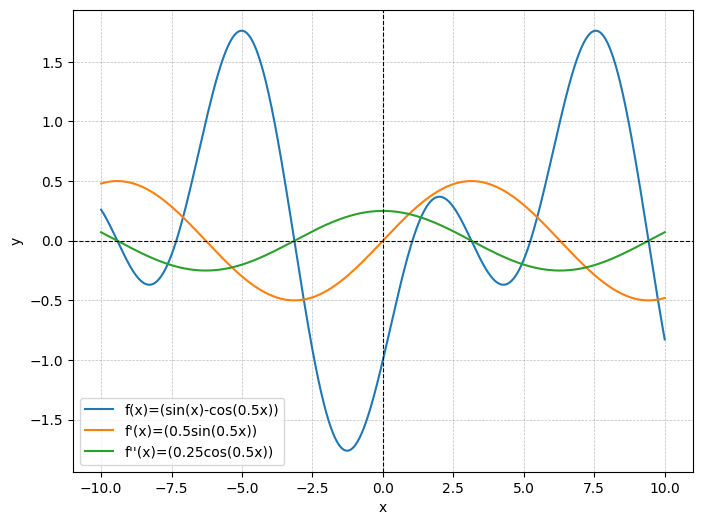

In [76]:
f = SumFunc("f", [ConstFunc("", -1), SinFunc(), CosFunc("",-1, 0.5)])
print(f)
Plottable.multi_plot([f, f.derive(), f.derive().derive()], -10, 10, 1000)

### Produktregel

Eine weitere Art, Funktionen zusammenzusetzen, ist die Multiplikation.

$$ f(x) = g(x) \cdot h(x) \rightarrow f'(x) = g'(x) \cdot h(x) + g(x) \cdot h'(x)$$


Aus einem Produkt entsteht nach der Ableitung also eine Summe aus zwei Produkten.

<div class="aufgabe">
    <h3>Produkt-Funktion</h3>
    <img src="images/sin_times_x_cubed.png" width=260 align=right alt="selfmade" />
    Ergänzen Sie den untenstehenden Code der Klasse <tt>ProdFunc</tt>, die ein Produkt aus zwei anderen Funktionen (<tt>left/right</tt>) ist.<br>
    Stellen Sie sicher, dass alle Tests durchlaufen!<br>
    Folgende Vorgaben gelten:
    <ul>
    <li><tt>__init__(self, name: str, left: MFunc, right: MFunc, factor: float = 1.0):</tt>: Alle Faktoren aus den beiden übergebenen Funktionen sollen als Faktor in die neue <tt>ProdFunc</tt> gezogen werden  (z.B. <tt>2.0sin(x)*3.0x->6.0sin(x)*x</tt>)
    </li>    
    <li><tt>_str_internal(self) -> str</tt>: Wir verwenden keine zusätzlichen Klammern, da Punkt-vor-Strich gilt.
    </li>    
    <li><tt>_call_internal(self, x: float) -> float</tt>: Berechnen Sie die Funktion durch Aufruf von <tt>left/right</tt>.
    </li>
    <li><tt>derive(self) -> MFunc</tt>: Das Ergebnis ist immer eine <tt>SumFunc</tt> aus zwei <tt>ProdFunc</tt>. Die Tests erwarten die Reihenfolge aus der Potenzregel.
    </li>
    </ul>
</div>

<details class="hint">
<summary></summary>
Faktoren werden durch Multiplikation miteinander kombiniert.
    <details class="nexthint">
    <summary></summary>
       Wenn Sie wissen, dass die beiden Elemente left und right factor=1.0 haben, wird die Ausgabe leichter.
        <details class="nexthint">
        <summary></summary>
           Erstellen Sie beim Ableiten die einzelnen Komponenten der Produktregel und setzen Sie sie dann zusammen.
        </details>
    </details>
</details>


In [77]:
import unittest

class ProdFunc(MFunc):

    def __init__(self, name: str, left: MFunc, right: MFunc, factor: float = 1.0):
        super().__init__(name, factor)
        self.left = left
        self.right = right

    def _str_internal(self) -> str:
        if self.right.factor != 1: 
            self.left.factor *= self.right.factor
            self.right.factor = 1
        if self.left._str_internal() == "1.0":
            return f"{self.right._str_internal()}"
        return f"{self.left._str_internal()}*{self.right._str_internal()}"

    def _call_internal(self, x: float) -> float:
        return self.left(x) * self.right(x) 

    def derive(self) -> MFunc:
        return SumFunc(self.name + "'", [ProdFunc("", self.left.derive(), self.right, self.factor), ProdFunc("", self.left, self.right.derive(), self.factor)])

    def integrate(self):
        #Nicht nötig
        return super().integrate()

class TestProdFunc(unittest.TestCase):
    """
    Unittests für die zusammengestzte Produkt-Funktion.
    """
    def setUp(self):
        """
        Initialisiere Variablen für den Test.
        """
        self.f = ProdFunc("f", PowerFunc("", 1.0, 2.0), SinFunc())
        self.g = ProdFunc("g", ExpFunc("", 2.0, 2.0), CosFunc("", 3.0))
        self.h = ProdFunc("h", SinFunc("", -1.0, 0.5), PowerFunc("", -3.0, 1.5))
        
    def test_01_call(self):
        """
        Testet korrekte Berechnung.
        """
        self.assertAlmostEqual(self.f(2.0), 3.637189707302727)
        self.assertAlmostEqual(self.f(3.0), 1.2700800725388048)
        self.assertAlmostEqual(self.g(2.0), -136.32508450571538)
        self.assertAlmostEqual(self.g(1.0), 23.953944290647627)
        self.assertAlmostEqual(self.g(-1.0), 0.43873179358835784)
        self.assertAlmostEqual(self.g(2.5), -713.4015292690831)

        
    def test_02_str(self):
        """
        Testet korrekte Ausgabe als String.
        """
        self.assertEqual(str(self.f),"f(x)=x^2.0*sin(x)")
        self.assertEqual(str(self.g),"g(x)=6.0e^(2.0x)*cos(x)")
        self.assertEqual(str(self.h),"h(x)=3.0sin(0.5x)*x^1.5")

    def test_03_derive(self):
        """
        Testet einmalige Ableitung.
        """
        fd= self.f.derive()
        gd= self.g.derive()
        hd= self.h.derive()

        self.assertTrue(type(fd) is SumFunc)
        self.assertEqual(len(fd.terms), 2)
        self.assertIn("f'(x)=(", str(fd))
        self.assertIn("2.0x*sin(x)", str(fd))
        self.assertIn("x^2.0*cos(x)", str(fd))
        
        self.assertIn("12.0e^(2.0x)*cos(x)", str(gd))
        self.assertIn("-6.0e^(2.0x)*sin(x)", str(gd))
        self.assertAlmostEqual(gd(0.0), 12.0)

        self.assertIn("1.5cos(0.5x)*x^1.5", str(hd))
        self.assertIn("4.5sin(0.5x)*x^0.5", str(hd))
        self.assertAlmostEqual(hd(math.pi), 7.976042329074822)

    
    #Bonus-Aufgabe
    def test_11_simplify(self):
        """
        Testet Die Vereinfachung/Zusammenfassung des Produkts.
        Benötigt Bonusaufgabe NestedFunc!
        """
        p1 = ProdFunc.simplify(ProdFunc("p", ConstFunc("", 17.0), ConstFunc("", 4.0)))
        self.assertTrue(type(p1) is ConstFunc)
        self.assertAlmostEqual(p1.factor, 68.0)

        p2 = ProdFunc.simplify(ProdFunc("p", PowerFunc("", 1.0, 2.0), PowerFunc("", 1.0, 3.0)))
        self.assertTrue(type(p2) is PowerFunc)
        self.assertAlmostEqual(p2.exponent, 5.0)

        p3 = ProdFunc.simplify(ProdFunc("p", ProdFunc("s", SinFunc("", 2.0, 1.0), ConstFunc("", 4.0)), PowerFunc("", -2.0, 3.0)))
        self.assertTrue(type(p3) is ProdFunc)
        self.assertAlmostEqual(p3.factor, -16.0)
        self.assertTrue(type(p3.left) in (SinFunc, PowerFunc))
        self.assertTrue(type(p3.right) in (SinFunc, PowerFunc))
        self.assertAlmostEqual(p3(1.0), -13.463535756926344)

        p4 = ProdFunc.simplify(ProdFunc("p", SinFunc("", 1.0, 2.0), SinFunc("", 1.0, 2.0)))
        self.assertTrue(type(p4) is NestedFunc)
        self.assertEqual(str(p4), "p(x)=sin(2.0x)^2")

     

    def test_12_derive_and_simplify(self):
        """
        Testet mehrfache Ableitung und simplify.
        """
        fdd= self.f.derive().derive()
        gddd= self.g.derive().derive().derive()
        hdd= self.h.derive().derive()
        
        self.assertEqual(len(fdd.terms), 3)
        self.assertIn("f''(x)=(", str(fdd))
        self.assertIn("2.0sin(x)", str(fdd))
        self.assertIn("4.0x*cos(x)", str(fdd))
        self.assertIn("x^2.0*sin(x)", str(fdd))

        self.assertEqual(len(gddd.terms), 2)
        self.assertIn("12.0e^(2.0x)*cos(x)", str(gddd))
        self.assertIn("-66.0e^(2.0x)*sin(x)", str(gddd))

        self.assertEqual(len(hdd.terms), 3)
        self.assertIn("-0.75sin(0.5x)*x^1.5", str(hdd))
        self.assertIn("4.5cos(0.5x)*x^0.5", str(hdd))
        self.assertIn("2.25sin(0.5x)*x^-0.5", str(hdd))


if __name__ == '__main__':

    #Test Newton
    h = ProdFunc("h", ProdFunc("", CosFunc("", 1, 5), ExpFunc("", 1, 1)), PowerFunc("", 1, 3))
    print(h.newton(-4, 4))

    #Durchführung der Tests
    loader = unittest.TestLoader()
    suite = unittest.TestSuite()

    #Hier können einzelne Tests auskommentiert werden
    suite.addTest(TestProdFunc("test_01_call"))
    suite.addTest(TestProdFunc("test_02_str"))
    suite.addTest(TestProdFunc("test_03_derive"))
    #Bonus-Aufgabe
    #suite.addTest(TestProdFunc("test_11_simplify"))
    #suite.addTest(TestProdFunc("test_12_derive_and_simplify"))
    
    runner = unittest.TextTestRunner()
    runner.run(suite)

..F
FAIL: test_03_derive (__main__.TestProdFunc.test_03_derive)
Testet einmalige Ableitung.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "c:\temp\rdstemp\OSC\ipykernel_10124\2128198715.py", line 69, in test_03_derive
    self.assertEqual(len(fd.terms), 2)
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^
AssertionError: 1 != 2

----------------------------------------------------------------------
Ran 3 tests in 0.006s

FAILED (failures=1)


[-1.2168555118641988e-05, -1.0082517098303356e-05, -7.648806074574958e-06, -5.562768054236335e-06, -3.4767300338977064e-06, -1.3906920135590835e-06, 0.0, 1.0430190101693127e-06, 3.1290570305079373e-06, 5.215095050846562e-06, 7.301133071185189e-06, 9.73484409491358e-06, 1.182088211525221e-05]


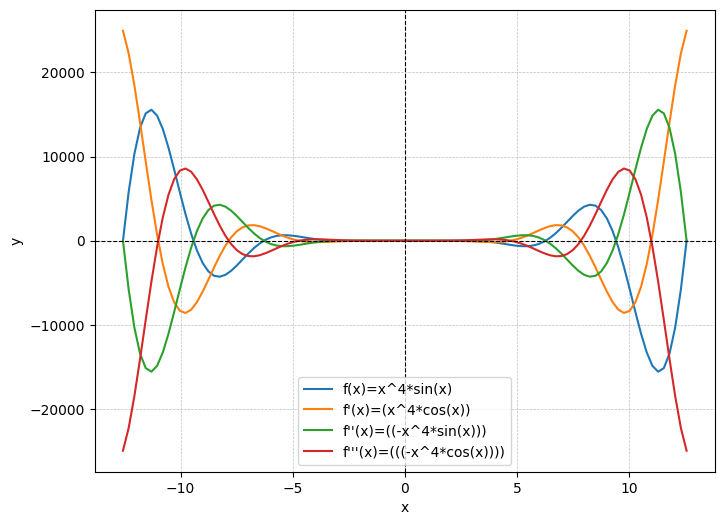

In [78]:
f = ProdFunc("f", PowerFunc("",1,4), SinFunc())
Plottable.multi_plot([f, 
                      f.derive(), 
                      f.derive().derive(),
                      f.derive().derive().derive()],
                     -4.0*math.pi, 4.0*math.pi)

### Bonus: Kettenregel <img src="images/bonusstar223679.png" width=40 align=right alt="https://openclipart.org/detail/223679/simple-3d-star" />

Bei verketteten Funktionen dient eine innere Funktion als Operand einer äußeren Funktion.

$$ 
f(x) = g(h(x)) \rightarrow f'(x) = g'(h(x)) \cdot h'(x)
$$
    Mehrere der bisher gezeigten Regeln sind Spezialfälle der Kettenregel, z.B.
$$
    f(x) = sin(c \cdot x), \text{ mit } g(x) = sin(x), h(x) = c \cdot x
$$
$$
\rightarrow g'(x) = cos(x), h'(x) = c, f'(x) = cos(h(x)) \cdot c = cos(c \cdot x) \cdot c
$$

Der Schlüssel zur Anwendung der Kettenregel ist es, eine Funktion geschickt in die äußere und innere Funktion zu zerlegen.

<div class="aufgabe">
    <img src="images/bonusstar223679.png" width=80 align=right alt="https://openclipart.org/detail/223679/simple-3d-star" />
    <h3>Verkettete Funktion</h3>
    Ergänzen Sie den untenstehenden Code der Klasse <tt>NestedFunc</tt>, die eine Verkettung einer äußeren und einer inneren Funktion (<tt>outer/inner</tt>) ist.<br>
    Stellen Sie sicher, dass alle Tests durchlaufen!<br>
    Folgende Vorgaben gelten:
    <ul>
    <li><img src="images/cos_cubed.png" width=220 align=right alt="selfmade" /><tt>__init__(self, name: str, outer: MFunc, inner: MFunc, factor: float = 1.0):</tt>: Der Faktor der äußeren Funktion wird als Faktor der neuen <tt>NestedFunc</tt> verwendet. Die innere Funktion dient als Operand der äußeren. (z.B. <tt>2.0sin(x)/1.5x^2->sin(1.5x^2)</tt>)
    </li>    
    <li><tt>_str_internal(self) -> str</tt>: Die innere Funktion dient als Operand der äußeren.
    </li>    
    <li><tt>_call_internal(self, x: float) -> float</tt>: Berechnen Sie die Funktion durch Aufruf von <tt>inner</tt>, dann <tt>outer</tt>.
    </li>
    <li><tt>derive(self) -> MFunc</tt>: Das Ergebnis ist immer eine <tt>ProdFunc</tt> aus einer <tt>NestedFunc</tt> und einer anderen. Ausnahmen:<br> Ist die äußere Funktion eine Potenz, fällt sie ggfs weg (z.B. <tt>h(x)^2.0->h(x)^1.0</tt>).<br> Ist die innere Ableitung eine Konstante, wird sie stattdessen als Faktor geführt. <tt>g'(h(x))*2.0->2.0g'(h(x))
    </li>
    </ul>
</div> 

<details class="hint">
<summary></summary>
Das Attribut operand wirkt sich lediglich auf die String-Ausgabe aus. Was Sie nicht ausgeben, muss keinen schönen Operanden haben.
    <details class="nexthint">
    <summary></summary>
       Erstellen Sie bei der Ableitung genau die einzelnen Elemente der Kettenregel und setzen Sie sie neu zusammen.
        <details class="nexthint">
        <summary></summary>
           Wenn Sie die ProdFunc richtig implementiert haben, sollten die Faktoren automatisch vorne landen.
        </details>
    </details>
</details>


<div class="remark">
    <h3>Zeit zum Refactoring...</h3>
    <p>
    Mit der Kettenregel könnten wir rückblickend unsere bestehenden Klassen vereinfachen.<br>
    So könnten die "inneren" Faktoren bei Sinus, Cosinus, und $e$-Funktion wegfallen.<br>
    Im Sinne der Übung sparen wir uns das aber und lassen diese überflüssigen Faktoren stattdessen einfach ungenutzt.
    </p>
</div>

In [79]:
import unittest

class NestedFunc(MFunc):

    def __init__(self, name: str, outer: MFunc, inner: MFunc, factor: float = 1.0):
        super().__init__(name, factor)
        self.outer = outer
        self.inner = inner

    def _str_internal(self) -> str:
        self.outer.operand = self.inner._str_internal()
        return self.outer._str_internal()

    def _call_internal(self, x: float) -> float:
        return self.outer(self.inner(x))

    def derive(self) -> MFunc:  
        d_outer = self.outer.derive()
        d_inner = self.inner.derive()
        new_outer = NestedFunc("", d_outer, self.inner.clone())  # Außen abgeleitet, innen gleich
        return ProdFunc(self.name + "'", new_outer, d_inner, self.factor)

    def integrate(self):
        #Nicht nötig
        return super().integrate()

class TestNestedFunc(unittest.TestCase):
    """
    Unittests für die verkettete Funktion.
    """
    def setUp(self):
        """
        Initialisiere Variablen für den Test.
        """
        self.f = NestedFunc("f", PowerFunc("", 1.0, 2.0), SinFunc())
        self.g = NestedFunc("g", CosFunc("", 3.0), ProdFunc("",  PowerFunc("", 1.0, 1.0), ExpFunc("", 1.0, 1.0)) )
        self.h = NestedFunc("h", ExpFunc("", 2.0, 1.0), SumFunc("", [SinFunc(), CosFunc()]) )
        
    def test_01_call(self):
        """
        Testet korrekte Berechnung.
        """
        self.assertAlmostEqual(self.f(0.0), 0.0)
        self.assertAlmostEqual(self.f(1.0), 0.7080734182735712)
        self.assertAlmostEqual(self.g(2.0), -1.7938600825330877)
        self.assertAlmostEqual(self.g(-1.0), 2.7992762267946256)
        self.assertAlmostEqual(self.h(-1.0), 1.479905895481268)
        self.assertAlmostEqual(self.h(0.0), 5.43656365691809)

        
    def test_02_str(self):
        """
        Testet korrekte Ausgabe als String.
        """
        self.assertEqual(str(self.f),"f(x)=sin(x)^2.0")
        self.assertEqual(str(self.g),"g(x)=3.0cos(x*e^x)")
        self.assertEqual(str(self.h),"h(x)=2.0e^((sin(x)+cos(x)))")

    def test_03_derive(self):
        """
        Testet einmalige Ableitung.
        """
        fd= self.f.derive()
        gd= self.g.derive()
        hd= self.h.derive()

        self.assertTrue(type(fd) is ProdFunc)
        self.assertEqual(str(fd), "f'(x)=2.0sin(x)*cos(x)")
        self.assertAlmostEqual(fd(1.0), 0.9092974268256818)
        
        self.assertEqual(str(gd), "g'(x)=-3.0sin(x*e^x)*(e^x+x*e^x)")
        self.assertAlmostEqual(gd(1.0), -6.699715904670079)

        self.assertEqual(str(hd), "h'(x)=2.0e^((sin(x)+cos(x)))*(cos(x)-sin(x))")
        self.assertAlmostEqual(hd(1.0), -2.398481179592898)

    
    #Ultimative Bonus-Aufgabe - kombiniert alle bisherigen Bonus-Aufgaben (SumFunc und ProdFunc)
    def test_11_derive_and_simplify(self):
        """
        Testet mehrfache Ableitung und simplify.
        """
        fdd= self.f.derive().derive()
        gdd= self.g.derive().derive()
        hdd= self.h.derive().derive()
        
        self.assertEqual(len(fdd.terms), 2)
        self.assertEqual(str(fdd), "f''(x)=(2.0cos(x)^2-2.0sin(x)^2)")
        self.assertAlmostEqual(fdd(2.0), -1.3072872417272239)

        self.assertEqual(len(gdd.terms), 2)
        self.assertIn("-3.0cos(x*e^x)*(e^x+x*e^x)^2", str(gdd))
        self.assertIn("-3.0sin(x*e^x)*(2.0e^x+x*e^x)", str(gdd))
        self.assertAlmostEqual(gdd(1.0), 70.79266266689739)

        self.assertEqual(len(hdd.terms), 2)
        self.assertIn("2.0e^((sin(x)+cos(x)))*(cos(x)-sin(x))^2", str(hdd))
        self.assertIn("2.0e^((sin(x)+cos(x)))*(-sin(x)-cos(x))", str(hdd))
        self.assertAlmostEqual(hdd(0.0), 0.0)




if __name__ == '__main__':
    #Durchführung der Tests
    loader = unittest.TestLoader()
    suite = unittest.TestSuite()

    #Hier können einzelne Tests auskommentiert werden
    suite.addTest(TestNestedFunc("test_01_call"))
    suite.addTest(TestNestedFunc("test_02_str"))
    suite.addTest(TestNestedFunc("test_03_derive"))
    #Bonus-Aufgabe
    #suite.addTest(TestNestedFunc("test_11_derive_and_simplify"))
    
    runner = unittest.TextTestRunner()
    runner.run(suite)

FFF
FAIL: test_01_call (__main__.TestNestedFunc.test_01_call)
Testet korrekte Berechnung.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "c:\temp\rdstemp\OSC\ipykernel_10124\3684730317.py", line 47, in test_01_call
    self.assertAlmostEqual(self.h(-1.0), 1.479905895481268)
    ~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: 3.433051399097807 != 1.479905895481268 within 7 places (1.953145503616539 difference)

FAIL: test_02_str (__main__.TestNestedFunc.test_02_str)
Testet korrekte Ausgabe als String.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "c:\temp\rdstemp\OSC\ipykernel_10124\3684730317.py", line 57, in test_02_str
    self.assertEqual(str(self.h),"h(x)=2.0e^((sin(x)+cos(x)))")
    ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: 'h(x)=2.0e^((cos(x)))' != 'h(x)=2.0e^((sin(x)+cos(x)))'
- h(x)=2.0e^((

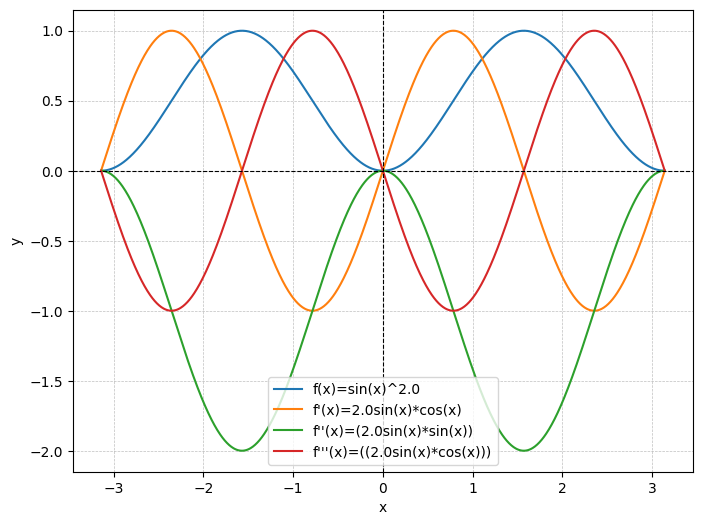

In [80]:
f = NestedFunc("f", PowerFunc("", 1.0, 2.0), SinFunc())
Plottable.multi_plot([f, 
                      f.derive(), 
                      f.derive().derive(),
                      f.derive().derive().derive()],
                      -math.pi, math.pi, 1000)

<div class="aufgabe">
    <h3> Produkt-Vereinfachung (schwer!)</h3>
    <img src="images/bonusstar223679.png" width=80 align=right alt="https://openclipart.org/detail/223679/simple-3d-star" />
    Ergänzen Sie eine statische Methode <tt>ProdFunc.simplify(infunc: ProdFunc) -> MFunc</tt>, die eine übergebene Produktfunktion vereinfacht:<br>
    <ul>
        <li>Mehrere gleiche Multiplikanden werden zu Exponenten (z.B. <tt>cos(x)*cos(x)->cos(x)^2.0</tt>)</li>
        <li>Kompatible Potenzen werden zusammengefasst (z.B. <tt>x^2.0*x^3.0->x^5.0</tt>)</li>
        <li>Konstantenfunktionen werden in den Faktor gezogen (z.B. <tt>2.0sin(x)*2.0->4.0sin(x)</tt>)</li>
        <li>Faktoren werden zusammengefasst, Konstanten in Potenzen ausmultipliziert (z.B. <tt>2.0(2.0x)^2->4.0x^2</tt>) </li>
        <li>Verbleibt nur ein Multiplikant, wird dieser direkt zurückgegeben (keine Produktfunktion)</li>
        <li>Verbleibt kein Multiplikant, wird eine Konstantenfunktion zurückgegeben</li>
    </ul>
    Alle diese Vereinfachungen sollen auch über mehrere ineinander verschachtelte Produkte hinweg umgesetzt werden.<br>
    Verwenden Sie diese Methode überall dort, wo Sie eine Produktfunktion erstellen.<br>
    Stellen Sie sicher, dass die zugehörigen Tests in <tt>ProdFunc</tt> und <tt>NestedFunc</tt> durchlaufen.
</div>